# Leakage Detection Framework
This is a framework for TVLA. The goal of this framework is to make it easier for researchers, scientists, or anyone interested in using TVLA for leakage detection.

## Basics
We will demonstrate a few of the functionalities of the framework below.
<br>
The combinations of the features, best practice suggestions, and other advanced parts (e.g. plotting) will be discussed later on in the documentation. The details about the underlying implementation and ways of extension will be discussed in each individual component of the framework.
<br>
<br>
### The Main Framework Class
For basic functionality, the only class that needs to be imported is the *LeakageDetectionFramework*:

In [1]:
from core import LeakageDetectionFramework

Using an instance of the *LeakageDetectionFramework*, we can already do a few basic things. We can already load trace data from an *npz* file that will automatically be loaded into and interpreted by a data handler class. We will touch on this later. For now we will focus on the framework instance itself, because the rest is happening under the hood.
<br>
The following code will load the trace data from the *npz* file and using Welch's t-test, it will calculate the t statistic.

In [2]:
from leak_calc import TestType
# Create the instance
ldf = LeakageDetectionFramework()

# Load the data
ldf.load_data("../traces/REASSURE_power_Unprotected_AES_fixed_vs_random_Exp1.npz")

# Calculate t_statistic using Welch's t-test
result = ldf.execute_test()
print(result)

<br>
The above methods processes the file and executes the TVLA test based on the information in the file so we can use the result generated by it for ourselves. We could print, for example the calculated T statistic which is used for extracting all of the other results showed below:

In [3]:
print('T-statistic: ', result.t_statistic)

T-statistic:  [-0.22990521  0.49794166  0.65197626 ... 33.54417795 32.84687168
 32.03226545]


We can also print the number of leaky points:

In [4]:
print('Number of leaky points: %.0f' % result.nr_of_leaky_points)

Number of leaky points: 11191


<br>
We could also look at the values for all of the leaky samples:

In [5]:
print('Leaky samples: ', result.leaky_samples)

Leaky samples:  [17.21989285 18.9699006  18.14778368 ... 33.54417795 32.84687168
 32.03226545]


<br>
Or fetch only the indices for the samples above:

In [6]:
print('Leaky indices: ', result.leaky_indices)

Leaky indices:  [ 2505  2506  2507 ... 15997 15998 15999]


<br>
The examples above are just to demonstrate the basic, default usage of the framework in case of TVLA and the usage of the TVLAResult class. The actual results were not entirely correct. The trace data also contains, for example the flushing of the cyphertext part of the algorithm which we don't need for executing TVLA. <br>
We will only be using the data until the dotted vertical line on the plot below (more on plotting later on). Here is the plot for the mean of all the traces (I will be using the MathUtil class for calculating the mean):

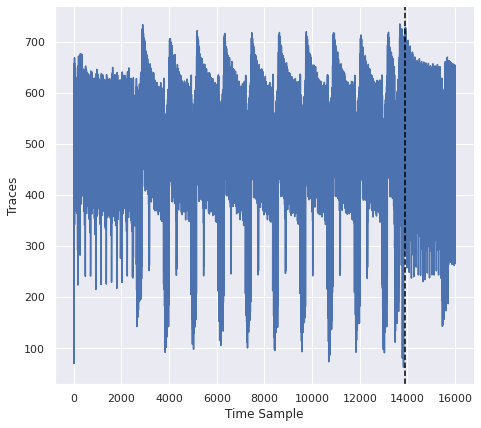

In [7]:
from leak_calc import MathUtil

math = MathUtil()
plotter = ldf.plotter()
plotter.create_line_plot(math.mean(ldf.trace_data().get_all_traces()), x="Time Sample", y="Traces").draw_vertical_line(13900).plot()

We will only execute the test for a certain range. As it can be seen from the diagram, the range of 0-13900 will do. We can achieve this very simply by calling the same function for executing the test, with the addition of a parameter:

In [8]:
result = ldf.execute_test(t_stat_range=range(0, 13900))
print(result)

TypeError: execute_test() got an unexpected keyword argument 't_stat_range'

After executing the test with the code above, we can check the results like we did before and see that the results are different:

In [9]:
print('T-statistic: ', result.t_statistic)
print('Number of leaky points: %.0f' % result.nr_of_leaky_points)
print('Leaky samples: ', result.leaky_samples)
print('Leaky indices: ', result.leaky_indices)

T-statistic:  [ -0.22990521   0.49794166   0.65197626 ... -11.58778067 -12.74171359
 -13.55217319]
Number of leaky points: 9390
Leaky samples:  [ 17.21989285  18.9699006   18.14778368 ... -11.58778067 -12.74171359
 -13.55217319]
Leaky indices:  [ 2505  2506  2507 ... 13897 13898 13899]


<br><br>
### Trace Data Class
The framework uses a few helper classes to keep everything more organized, maintainable and more easy to scale. One of these classes is called *TraceData*. This is used to store the data that the framework loads from the *npz* file. We can use the functions of this helper class to fetch different parts of the information that we wish to work with, visualise, extend, etc.
<br>
The *TraceData* class is designed to be a [singleton](https://www.tutorialspoint.com/python_design_patterns/python_design_patterns_singleton.htm). The reason behind this decision is that we do not wish to create new instances every time we load data sets for our tests. This way we can re-use the instances in case we would like to load in new data files. The reason is that the *TraceData* is actually part of the classes that contain the logic of each individual type of test. This means that, for example if we want to re-run TVLA a second time on a different dataset, then the class using the *TraceData* doesn't have to create a new instance.
<br>
Using the trace data is simple, we only need to call the following function from our *ldf* instance as we did above in the example with the plot:

In [10]:
trace_data = ldf.trace_data()

<b>Important note:</b> before using it we need to remember that in [this section](#The-Main-Framework-Class) we loaded the data from the *npz* file using the framework. This step is a must before fetching data from the class's instance.

<br>
#### Fetching the Trace Data

To get all the trace data from the file:

In [11]:
print('Every trace: \n%s' % trace_data.get_all_traces())

Every trace: 
[[482. 594. 416. ... 527. 626. 584.]
 [502. 272. 410. ... 529. 633. 590.]
 [477. 588. 409. ... 514. 621. 580.]
 ...
 [591. 271. 410. ... 528. 632. 589.]
 [474. 586. 414. ... 320. 460. 478.]
 [592. 281. 412. ... 517. 624. 583.]]


Here we should have 16000 traces, but printing all of them doesn't make sense so to see if we indeed get all of them, we can print teh lenght of the same array:

In [12]:
print(len(trace_data.get_all_traces()))

2000


<br>
To get all the fixed traces from the file (this is based on the fixed flag that is used in the dataset):

In [13]:
print('Fixed traces: \n%s' % trace_data.get_every_fixed_trace())

Fixed traces: 
[[482. 594. 416. ... 527. 626. 584.]
 [502. 272. 410. ... 529. 633. 590.]
 [477. 588. 409. ... 514. 621. 580.]
 ...
 [493. 265. 405. ... 508. 616. 575.]
 [591. 271. 410. ... 528. 632. 589.]
 [592. 281. 412. ... 517. 624. 583.]]


<br>
To get all the random traces from the file (this is based on the fixed flag that is used in the dataset):

In [14]:
print('Random traces: \n%s' % trace_data.get_every_random_trace())

Random traces: 
[[593. 271. 410. ... 327. 466. 482.]
 [477. 587. 416. ... 511. 622. 586.]
 [595. 271. 405. ... 329. 466. 482.]
 ...
 [485. 595. 419. ... 155. 330. 379.]
 [494. 280. 416. ... 518. 623. 587.]
 [474. 586. 414. ... 320. 460. 478.]]


We have seen that we can use the *TraceData* to fetch the kinds of traces we have in the data set, but what about working with only one sample of traces?
<br>
We can simply fetch a sample of traces using another function from the *TraceData* class to which we pass a parameter that represents the sample that we want to fetch:

In [15]:
sample = 15234

print('Trace sample %.0f: %s' % (sample, trace_data.get_trace_sample(sample)))
print('Fixed trace sample %.0f: %s' % (sample, trace_data.get_fixed_trace_sample(sample)))
print('Random trace sample %.0f: %s' % (sample, trace_data.get_random_trace_sample(sample)))

Trace sample 15234: [468. 456. 453. ... 454. 535. 459.]
Fixed trace sample 15234: [468. 456. 453. ... 442. 454. 459.]
Random trace sample 15234: [520. 463. 516. 532. 636. 565. 534. 504. 375. 575. 576. 510. 464. 513.
 532. 621. 614. 397. 413. 345. 612. 333. 542. 605. 617. 465. 397. 469.
 456. 534. 361. 465. 459. 578. 397. 608. 350. 465. 351. 509. 329. 527.
 455. 408. 534. 517. 285. 466. 401. 460. 531. 527. 609. 479. 561. 362.
 364. 407. 365. 528. 516. 453. 532. 577. 518. 368. 468. 405. 350. 451.
 406. 474. 501. 515. 517. 483. 602. 524. 457. 468. 510. 521. 523. 639.
 529. 375. 485. 468. 607. 467. 460. 360. 630. 330. 475. 357. 404. 489.
 471. 513. 515. 401. 576. 455. 363. 476. 531. 374. 527. 642. 344. 522.
 544. 517. 403. 350. 520. 539. 582. 617. 352. 521. 518. 527. 404. 587.
 466. 619. 470. 525. 356. 470. 599. 493. 605. 586. 470. 595. 610. 471.
 511. 537. 471. 466. 361. 579. 526. 642. 481. 507. 472. 361. 579. 482.
 516. 528. 409. 583. 369. 470. 498. 409. 402. 475. 607. 510. 475. 410.
 40

<br>
Currently, we have mostly seen the format that we imported from the *npz* file and used almost everything as numpy arrays. It is sometimes useful to have the data in other formats too. For example, when we are using the plotting functionality of the framework, we need to use [*DataFrame*](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) class to visualize the data. This is part of the *pandas* library and it uses a tabular data format.

<br>
When we use the *DataFrame* class we can name the headers of the columns that will represent the data in the rows of our structure. For this we can use the following utility function of the *TVLAData* class:

In [16]:
trace_data.convert_t_statistic_to_data_frame(result.t_statistic)

,Time Samples,T-Statistic
0,0,-0.229905
1,1,0.497942
2,2,0.651976
3,3,0.141892
4,4,0.010075
...,...,...
13895,13895,-8.388279
13896,13896,-10.154328
13897,13897,-11.587781
13898,13898,-12.741714


The code above used the instance of the *TVLAResult* class to fetch the T statistic we got from our calculations.
<br>
As we can see, by default the function names the headers of the two columns "Time Samples" and "T-Statistic". This is the default behaviour because this conversion is specifically useful when we would like to plot the T-Statistic data. The reason is that if we would like to use a pline plot and show the correct names of the x and y coordinates, then the *DataFrame* in this format is useful for this.
<br>
When we call the function above, under the hood we are actually using another function that is more generic and can be used for data other than T-Statistic. For example, if we would like to use the first set of the random traces and the time samples of those traces:

In [17]:
time_samples = range(0, len(trace_data.get_every_random_trace()[0]))
trace_data.convert_to_data_frame(data_x=time_samples, data_y=trace_data.get_every_random_trace()[0], x="T Samples", y="Random Traces")

,T Samples,Random Traces
0,0,593.0
1,1,271.0
2,2,410.0
3,3,418.0
4,4,545.0
...,...,...
15995,15995,589.0
15996,15996,676.0
15997,15997,327.0
15998,15998,466.0


Notice how the headers are not the same as in the example before because here we specified the values. This part is going to be especially useful when it comes to plotting.

<br><br>
### Plotting
In this section we discuss the plotting functionality of the framework.
Plotting any data can be achieved by fetching the plotter from the main instance of the framework class. We discussed about the main class above, where we instantiated it with the following code segment:

In [18]:
ldf = LeakageDetectionFramework()

Using the main framework class, we can fetch an instance of the *Plotter* class. This class uses visualisation tools, such as [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/) under the hood.
Getting a new instance of the *Plotter* class is simple:

In [19]:
plotter = ldf.plotter()

#### Creating Plots
When it comes to working with plots, the most important aspect of this framework is ease of use. Plotting data in a fashion that it is simple and fast is not always possible. Many times we have to write many lines of code to properly configure a plot for a certain context (by context we mean plot type, size, etc.), not being able to simply create multiple plots reusing the same context. Moreover, if we want to create two plots of the same data in the same context, but just make the second plot a little bit different, for example by highlighting a few points, drawing a line to split the plot with a certain logic in mind, we cannot do it without having to rewrite the same 10-15 lines of code and adding the 2-3 lines that we need for the extra highlighting.

<br>
This is where this framework's *Plotter* class comes in. The direction we wanted to take this class was to make it as easy as possible for the users to create as many plots as they want without any of the headache certain libraries could give them.
The idea was to declare a **chain** of plots that the user would like to display and plot that without any additional parameter tweaking or other complicated things.

<br>
##### Line Plots
Let's say that the user would like to compare two sets of data. In our case it would make sens to look at the initial power trace that we extract from the data file and the T-Statistic after our calculations. We already calculated everything above, so as we discussed in [this section](#Trace-Data-Class), we can just conveniently re-use the *TVLAData* class' instance and use the data for plotting.

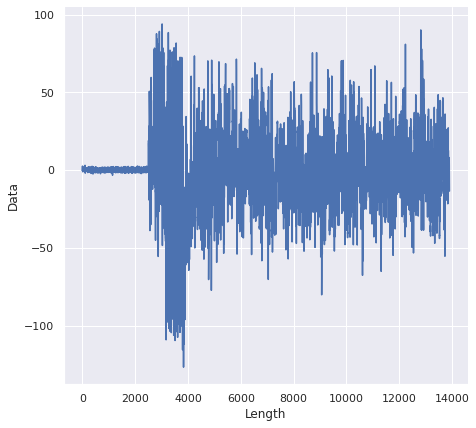

In [20]:
plotter.create_line_plot(result.t_statistic).plot()

Remember that we need to convert our data into *DataFrame* using the helper functions that we've discussed about above. Conveniently enough, the *Plotter* class takes care of this part for us. This way we are not forced to convert from our structure to *DataFrames* back and forth, we can just pass our data to the plotter and it will do the conversion locally so it can do the plotting without issues.

<br>
Note that we need to call the *plot* function at the end of the **chain** of functions when we are using the plotter.
We say chain because, let's say we would like to plot the T-Statistic and the original power trace next to each other. To achieve that we would need to call the function that we just used above twice:

In [21]:
plotter.create_line_plot(result.t_statistic).create_line_plot(trace_data.get_all_traces()).plot()

ValueError: Data must be 1-dimensional

As we can see it is really simple to create two consecutive plots with different data. We can also observe that the default label for the x and y coordinates are "Length" and "Data". Fortunately, we can use arbitrary labels for the coordinates, we just have to pass them as parameters to the plotting functions as such:

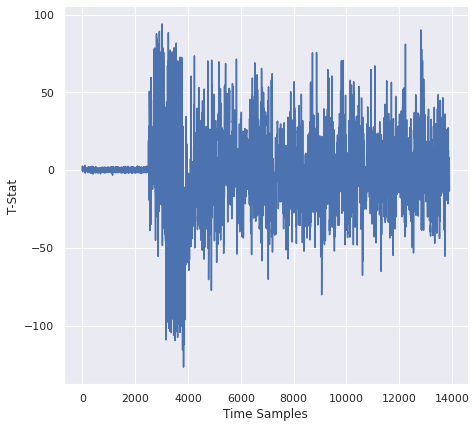

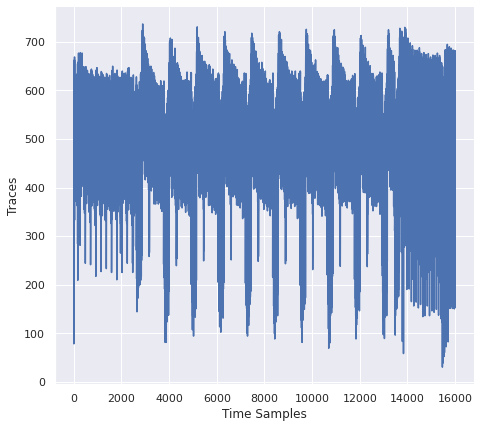

In [21]:
plotter.create_line_plot(result.t_statistic, x="Time Samples", y="T-Stat").create_line_plot(trace_data.get_all_traces(), x="Time Samples", y="Traces").plot()

Above we displayed two plots by chaining the function *create_line_plot* from the Plotter class. We can do this as many times as we need, keeping in mind that if we do this too many times we can have overlapping windows of plots (this of course depends on the resolution of our monitor).
<br>
We can also add a few extras to our plots. Lets say that we would like to highlight the leaky samples in our power trace. We can use the *highlight_points* function of the Plotter to highlight points on the plot in a certain way.
For this demo we will highlight random coordinates on the plot just to demonstrate the ease of use of the plotting framework:

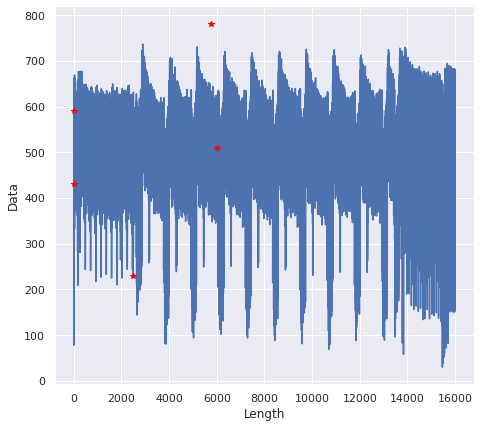

In [22]:
coord = ((12, 430), (30, 590), (2500, 230), (5760, 781), (6000, 510))
plotter.create_line_plot(trace_data.get_all_traces()).highlight_points(coord).plot()

The highlights appear with red stars ("*") by default but this can be configured with any other symbol and color that is available in the matplotlib library. E.g.:

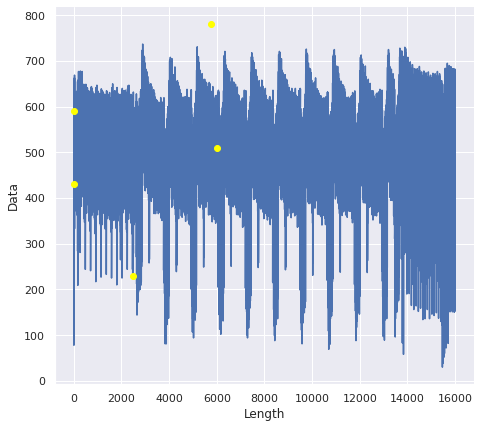

In [23]:
coord = ((12, 430), (30, 590), (2500, 230), (5760, 781), (6000, 510))
plotter.create_line_plot(trace_data.get_all_traces()).highlight_points(coord, marker="o", color="yellow").plot()

Also, if we would like to change the underlying color of the lines so that the highlighted points marked with the yellow circles are more visible, we can simply call the *change_color* function of the plotter:

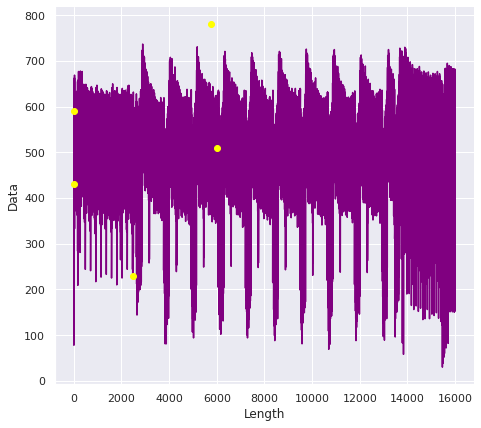

In [24]:
plotter.change_color("purple")
coord = ((12, 430), (30, 590), (2500, 230), (5760, 781), (6000, 510))
plotter.create_line_plot(trace_data.get_all_traces()).highlight_points(coord, marker="o", color="yellow").plot()

Note that after we change the color, every plot that we create will be displayed with the color we choose. We can of course go back to the default color by calling the *default_color* function of the plotter:

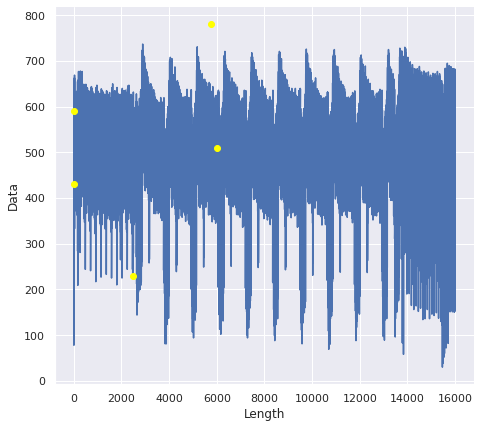

In [25]:
plotter.default_color()
coord = ((12, 430), (30, 590), (2500, 230), (5760, 781), (6000, 510))
plotter.create_line_plot(trace_data.get_all_traces()).highlight_points(coord, marker="o", color="yellow").plot()

We can also draw horizontal lines on the line plots. This can be useful if we would like to mark certain thresholds for example. All we need to do is specify the value of the y coordinate on which we would like to draw the line, using the *draw_horizontal_line* function.
This is useful for example if we would like to highlight the threshold that we used in our T-Test. In this example I am using 4.5 and -4.5:

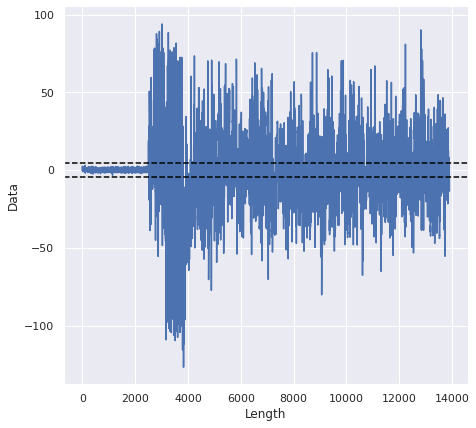

In [26]:
plotter.create_line_plot(result.t_statistic).draw_horizontal_line(4.5).draw_horizontal_line(-4.5).plot()

The example above is something that is used often enough that we created a simplification for it in the form of the *show_threshold* function. This function is a wrapper for the example above, so we don't have to use the *draw_horizontal_line* twice. But there are certain cases when we want to draw only one line so in those cases it is useful to have that function as well.

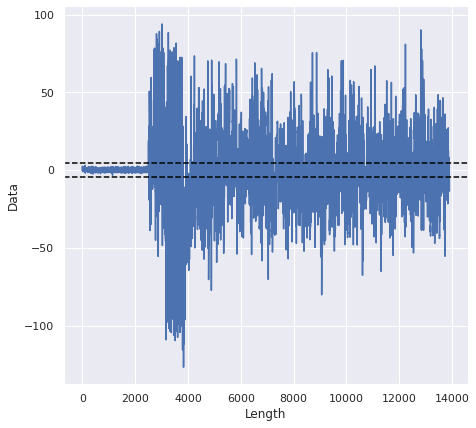

In [27]:
plotter.create_line_plot(result.t_statistic).show_threshold(4.5).plot()

Just like in the other plotting functions above, we consider that allowing the user to tune the plots to his/her liking is important. This is why we can change the color and the line style the way we want, as long as the color and style is in within what the library allows.
<br>
Moreover, since we can draw the two lines separately, we can also change the style of each individual line so they can represent different things, if the user would like them to.
Lets say we would like the lines to be red and instead of the dashed lines we want solid lines:

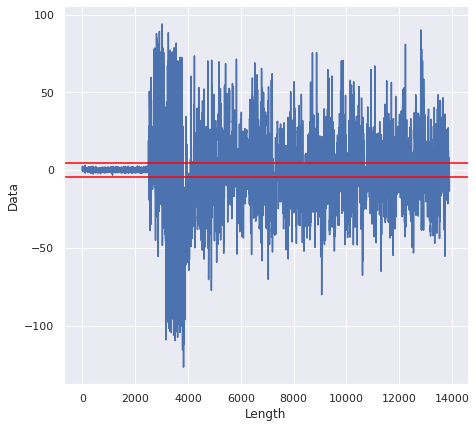

In [28]:
plotter.create_line_plot(result.t_statistic).show_threshold(4.5, color="red", ls="solid").plot()

<br>
We can also draw vertical lines similarly to the way we did with the horizontal ones. In this case we need to call the *draw_vertical_line* function, this time instead of a value for the y coordinate, we have to pass a value for the x coordinate.
Lets say we would like to show the 3 main parts of the power trace of running an AES-128 algorithm. We can easily do that on the line diagram of the full power trace and calling the *draw_vertical_line* function twice with the values 2500 and 14000.

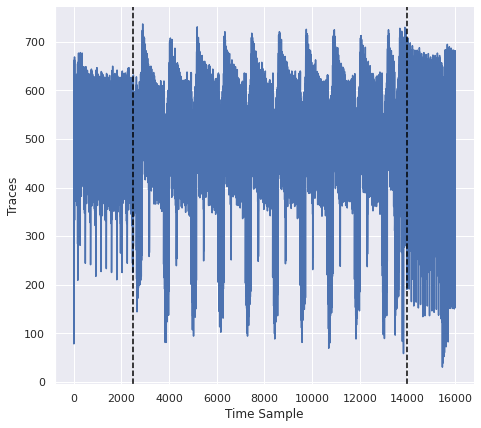

In [29]:
plotter.create_line_plot(trace_data.get_all_traces(), x="Time Sample", y="Traces").draw_vertical_line(2500).draw_vertical_line(14000).plot()

The reason we choose 2500 and 14000 is because it can be seen on the plot that the first section happens before sample ~2500, the second section is between ~2500 and ~14000 and the last part is after ~14000. In the first part the 10 round keys are generated, in the second part we can see the power activity of the AES algorithm itself and the last part contains the flushing of the ciphertext.

<br>
##### Hist Plots
We can also create histograms. These plots are useful in case we would like to display frequency distributions. For example, if we would like to see the frequency distribution of a certain sample of the random traces, it would look like this:

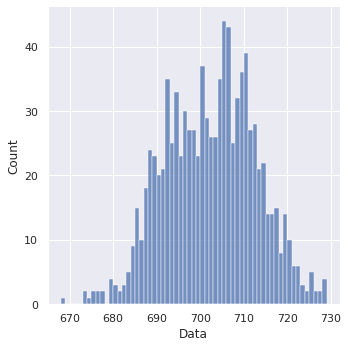

In [30]:
sample = 7500
plotter.create_hist_plot(trace_data.get_every_random_trace()[:, sample]).plot()

If we would like to compare the frequency distribution of the same sample from the random and fixed traces, all we would need to do is to chain the two hsitograms together, like we did with the line plots. This could be useful if we would like to compare the two plots.
We can also add labels to the plots, for example if we would like to distinguish the two plots from each other:

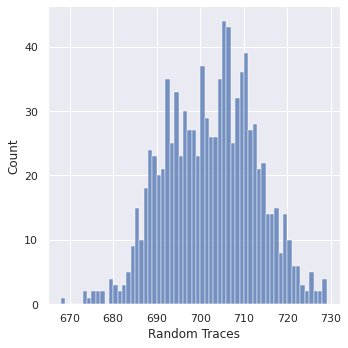

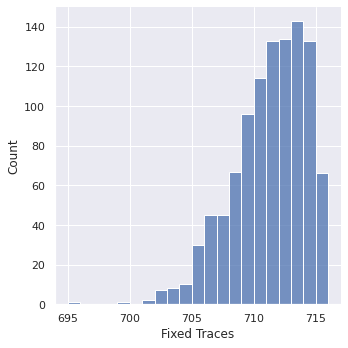

In [31]:
sample = 7500
random_trace_sample = trace_data.get_random_trace_sample(sample)
fixed_trace_sample = trace_data.get_fixed_trace_sample(sample)
plotter.create_hist_plot(random_trace_sample, label="Random Traces").create_hist_plot(fixed_trace_sample, label="Fixed Traces").plot()